<a href="https://www.kaggle.com/code/tirendazacademy/cancer-detection-with-pytorch-lightning?scriptVersionId=128996594" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Image Classification with PyTorch-Lightning
![](https://img.freepik.com/free-vector/process-cancer-cell-development_1308-98254.jpg?w=1380&t=st=1683703025~exp=1683703625~hmac=c97f17908421e06077a85bc5122ccacd44d85eff4c237734edabc89a750a5cd0)

Hi guys 😀 In this notebook, we'll walk you through how to implement image classification with PyTorch-Ligthning. 

Table of contents:
<ul>
<li><a href="#importing">Importing required libraries </a></li>  
<li><a href="#data-importing">Importing the dataset </a></li>  
<li><a href="#understanding">Understanding the dataset</a></li>         
<li><a href="#data-preprocessing">Data preprocessing</a></li>   
<li><a href="#data-loading">Loading the dataset</a></li>
<li><a href="#model-building">Building the model</a></li>
<li><a href="#model-traning">Trainging the model</a></li>
<li><a href="#model-prediction">Model prediction</a></li>      
<li><a href="#conclusion">Conclusion</a></li>   
</ul>

I'm excited, let's get started right away 🚀

<a id='importing'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Importing Required Libraries </div></b>

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy
from torchvision.models import resnet50, ResNet50_Weights

import pytorch_lightning as pl

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("torch version:",torch.__version__)
print("pytorch ligthening version:",pl.__version__)

torch version: 2.0.0
pytorch ligthening version: 2.0.1.post0


<a id='data-importing'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Importing the Dataset </div></b>

In [3]:
cancer_labels = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
cancer_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


<a id='understanding'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Understanding the Dataset </div></b>

In [4]:
base_dir = '../input/histopathologic-cancer-detection/'
print("Train Size: {}".format(len(os.listdir(f'{base_dir}train'))))
print("Test Size: {}".format(len(os.listdir(f'{base_dir}test'))))

Train Size: 220025
Test Size: 57458


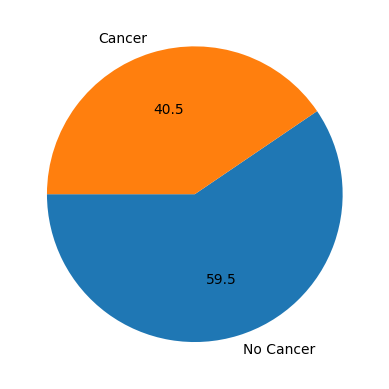

<Figure size 1600x1600 with 0 Axes>

In [5]:
labels_count = cancer_labels.label.value_counts()

plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=180, autopct='%1.1f')
plt.figure(figsize=(16,16))
plt.show()

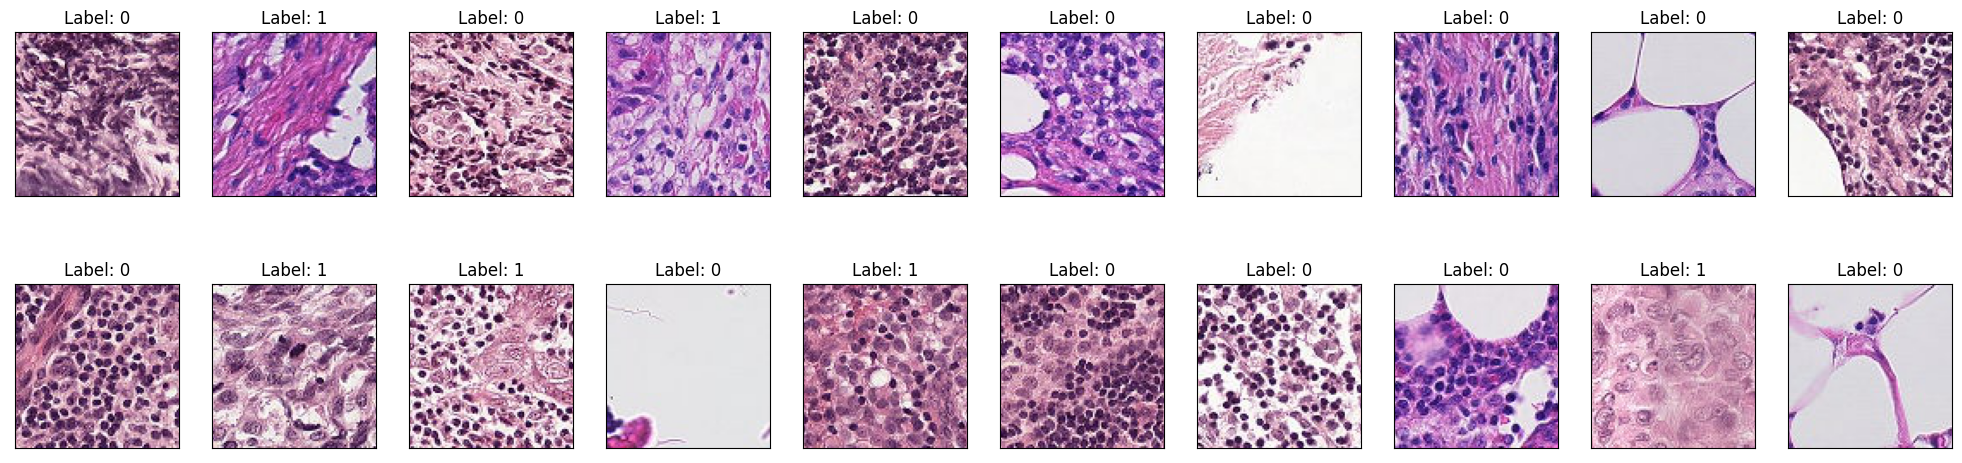

In [6]:
fig = plt.figure(figsize=(25, 6))

train_imgs = os.listdir(base_dir+"train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"train/" + img)
    plt.imshow(im)
    lab = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

<a id='data-preprocessing'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Data Preprocessing</div></b>

In [7]:
np.random.seed(0)
train_imgs_orig = os.listdir("/kaggle/input/histopathologic-cancer-detection/train")
selected_image_list = []
for img in np.random.choice(train_imgs_orig, 10000):
    selected_image_list.append(img)
len(selected_image_list)

10000

In [8]:
np.random.seed(0)
np.random.shuffle(selected_image_list)
cancer_train_idx = selected_image_list[:8000]
cancer_test_idx = selected_image_list[8000:10000]
print("Number of images in the downsampled training dataset: ", len(cancer_train_idx))
print("Number of images in the downsampled testing dataset: ", len(cancer_test_idx))

Number of images in the downsampled training dataset:  8000
Number of images in the downsampled testing dataset:  2000


In [9]:
os.mkdir('/kaggle/working/cancer_train_dataset/')
for fname in cancer_train_idx:
    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', fname)
    dst = os.path.join('/kaggle/working/cancer_train_dataset', fname)
    shutil.copyfile(src, dst)
print('Number of images in downsampled training dataset: ', len(os.listdir("/kaggle/working/cancer_train_dataset")))

Number of images in downsampled training dataset:  7847


In [10]:
os.mkdir('/kaggle/working/cancer_test_dataset/')
for fname in cancer_test_idx:
    src = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', fname)
    dst = os.path.join('/kaggle/working/cancer_test_dataset/', fname)
    shutil.copyfile(src, dst)
print('Number of images in downsampled testing dataset: ', len(os.listdir("/kaggle/working/cancer_test_dataset/")))

Number of images in downsampled testing dataset:  1989


In [11]:
selected_image_labels = pd.DataFrame()
id_list = []
label_list = []

for img in selected_image_list:
    label_tuple = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0]]
    id_list.append(label_tuple['id'].values[0])
    label_list.append(label_tuple['label'].values[0])

In [12]:
selected_image_labels['id'] = id_list
selected_image_labels['label'] = label_list
selected_image_labels.head()

,id,label
0,f4fdc910da56063188ea442d307178abbbacfdfc,0
1,3eda6ab16d1edebe3ecf608ee2b14d68c68b8666,1
2,17e643a00e78ea98cf55e6e33e3e208de9965868,0
3,5868d1d23be2a49ffb9dc6d2ac97c323808db6de,1
4,fbfe6e61423639e320773483ce52f47c494054fb,0


In [13]:
img_class_dict = {k:v for k, v in zip(selected_image_labels.id, selected_image_labels.label)}

<a id='data-loading'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Loading the Dataset</div></b>

 ## Data Augmentations

In [14]:
data_T_train = T.Compose([
    T.Resize(224),
    T.RandomHorizontalFlip(),
    T.ToTensor()])

data_T_test = T.Compose([
    T.Resize(224),
    T.ToTensor()])

In [15]:
class LoadCancerDataset(Dataset):
    def __init__(self, datafolder, transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), labels_dict={}):
        self.datafolder = datafolder
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform
        self.labels_dict = labels_dict
        self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.image_files_list[idx].split('.')[0]
        label = self.labels_dict[img_name_short]
        return image, label

In [16]:
cancer_train_set = LoadCancerDataset(datafolder='/kaggle/working/cancer_train_dataset', transform=data_T_train, labels_dict=img_class_dict)
cancer_test_set = LoadCancerDataset(datafolder='/kaggle/working/cancer_test_dataset', transform=data_T_test, labels_dict=img_class_dict)

In [17]:
batch_size = 128

cancer_train_dataloader = DataLoader(cancer_train_set, batch_size, num_workers=2, pin_memory=True, shuffle=True)
cancer_test_dataloader = DataLoader(cancer_test_set, batch_size, num_workers=2, pin_memory=True)

<a id='model-building'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Buiding the Model</div></b>

In [18]:
#resnet50(pretrained=True)
class CancerImageClassifier(pl.LightningModule):

    def __init__(self, learning_rate = 0.001):   
        super().__init__()
        self.learning_rate = learning_rate
        self.loss = nn.CrossEntropyLoss()   
        
        self.pretrain_model = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.pretrain_model.eval()
        for param in self.pretrain_model.parameters():
            param.requires_grad = False
        self.pretrain_model.fc = nn.Linear(2048, 2)

    def forward(self, input):
        output=self.pretrain_model(input)
        return output

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs) 
        preds = torch.argmax(outputs, dim=1)
        train_accuracy = accuracy(preds, targets, task="binary")
        loss = self.loss(outputs, targets)
        self.log('train_accuracy', train_accuracy, prog_bar=True)
        self.log('train_loss', loss)
        return {"loss":loss, 'train_accuracy': train_accuracy}
      
    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        preds = torch.argmax(outputs, dim=1)
        test_accuracy = accuracy(preds, targets, task="binary")
        loss = self.loss(outputs, targets)
        # self.log('test_accuracy', test_accuracy, prog_bar=True)
        return {"test_loss":loss, "test_accuracy":test_accuracy}
    
    def on_test_epoch_end(self, outputs):
        test_outs = []
        for test_out in outputs:
            out = test_out['test_accuracy']
            test_outs.append(out)
        total_test_accuracy = torch.stack(test_outs).mean()
        self.log('total_test_accuracy', total_test_accuracy, on_step=False, on_epoch=True)
        return total_test_accurac


    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.Adam(params=params, lr = self.learning_rate)
        return optimizer

In [19]:
model = CancerImageClassifier()

trainer = pl.Trainer(fast_dev_run=True, accelerator="auto", devices="auto")
trainer.fit(model, cancer_train_dataloader)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

<a id='model-traing'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Training the Model</div></b>

In [20]:
ckpt_dir = "/kaggle/working/transfer_learning"
ckpt_callback = pl.callbacks.ModelCheckpoint(every_n_epochs=10)

model = CancerImageClassifier()
trainer = pl.Trainer(default_root_dir=ckpt_dir,
                     accelerator="auto", 
                     devices="auto",
                    #  progress_bar_refresh_rate=30,
                    callbacks=[ckpt_callback],
                    log_every_n_steps=30,
                    max_epochs=5)
trainer.fit(model, train_dataloaders=cancer_train_dataloader)

Training: 0it [00:00, ?it/s]

<a id='model-prediction'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Model Prediction</div></b>

In [21]:
model.eval()
preds = []
for batch_i, (data, target) in enumerate(cancer_test_dataloader):
    target = target.cuda()
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

In [22]:
test_preds = pd.DataFrame({'imgs': cancer_test_set.image_files_list, 'labels':cancer_test_set.labels,  'preds': preds})
test_preds['imgs'] = test_preds['imgs'].apply(lambda x: x.split('.')[0])
test_preds['predictions'] = 1
test_preds.loc[test_preds['preds'] < 0, 'predictions'] = 0
test_preds.head()

,imgs,labels,preds,predictions
0,485176e89896b36bc40aa168505925b3c6f2a081,1,1.567496,1
1,89dead1db764fed7cae4dc0808f9b18431995c66,0,0.755946,1
2,12bc3646646b230e1083ad06d83a9206a7445a73,0,-1.483549,0
3,595c9cf9baaad136f20903ba77c9acd0bb185cd1,0,0.213017,1
4,8359aa1b447ec7a46fbf327bd451042c367ec884,0,-1.208478,0


In [23]:
len(np.where(test_preds['labels'] == test_preds['predictions'])[0])/test_preds.shape[0]

0.8562091503267973

<a id='conclusion'></a>
# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Conclusion</div></b>

In this notebook, we learned how to perform image classification with PyTorch-Lightning. Thanks for taking the time! If you enjoyed it, please consider upvoting.


🔗 Let's connect [YouTube](http://youtube.com/tirendazacademy) | [Medium](http://tirendazacademy.medium.com) | [Twitter](http://twitter.com/tirendazacademy) | [Instagram](https://www.instagram.com/tirendazacademy) | [GitHub](http://github.com/tirendazacademy) | [Linkedin](https://www.linkedin.com/in/tirendaz-academy) | [Kaggle](https://www.kaggle.com/tirendazacademy) 😎

## Resource
- [Deep Learning with PyTorch Lightning](https://www.amazon.com/dp/180056161X)